<a href="https://colab.research.google.com/github/J-DR1/MastersThesis/blob/main/1_KDD_Contamination_0_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Packages

---



In [ ]:
#Basic Packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#Pyod
try:
  import pyod
except:
  !pip install pyod
finally:
  import pyod
  from pyod.models.iforest import IForest
  from pyod.models.ocsvm import OCSVM
  from pyod.models.lof import LOF
  from pyod.models.cblof import CBLOF
  from pyod.models.knn import KNN
  from pyod.utils.data import evaluate_print

#Isotree
try:
  import isotree
except: 
  !pip install isotree
finally:
  from isotree import IsolationForest

#Machine Learning - Sci-kit Learn
##Pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing

##Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix

##Hyper Parameter Tuning
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import GridSearchCV

#Warnings
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#Functions 

---



In [ ]:
#Functions 

#Train-test splits
def random_sample_from_kdd(full_dataframe, train_size, test_size, random_state = 1):
    train_set = full_dataframe.sample(random_state = random_state, n = train_size)
    train_X = train_set.drop('Attack Type', axis = 1) 
    train_y = train_set['Attack Type']
    test_set = full_dataframe.drop(train_set.index).sample(random_state = random_state, n = test_size)
    test_X = test_set.drop('Attack Type', axis = 1)
    test_y = test_set['Attack Type']
    return train_X, test_X, train_y, test_y

#Prints true contamination rate
def get_contamination_percentages(label_series, normal_value):
    return len(label_series[label_series != normal_value])/len(label_series)

#Fitting and predictions      
def get_prediction(classifier, train_X, test_X, train_y, test_y, normal_value, model_name ='', scaler = None, Oversample = False):
    #Standardization
    if (scaler is not None):
      train_X = scaler.fit_transform(train_X)
      test_X = scaler.transform(test_X)

    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)

    #Categorize the outliers to 1 and normals to 0
    if (Oversample):
      list_trainy = train_y
    else:
      list_trainy = list(train_y)
      for i in range(len(list_trainy)):
        if (list_trainy[i] == normal_value):
          list_trainy[i] = 0
        else:
          list_trainy[i] = 1

    list_testy = list(test_y)
    for i in range(len(list_testy)):
      if (list_testy[i] == normal_value):
        list_testy[i] = 0
      else:
        list_testy[i] = 1
  
    #Evaluate using Pyod built-in function
    print("On Training Data:")
    evaluate_print(model_name, list_trainy, clf.decision_scores_) #raw outlier scores
    print("\nOn Test Data:")
    evaluate_print(model_name, list_testy, clf.decision_function(test_X)) #decision_function(X_test): outlier scores for predicted test data
  
    print("\n", model_name, " Classification Report: \n" , classification_report(list_testy, pred, target_names= ['Normal', 'Anomaly']))
    print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(list_testy, pred))
    print("\n", model_name, "f1-score", f1_score(list_testy, pred))

    #Plots confusion matrix
    plt.figure()
    sns.heatmap(data = confusion_matrix(list_testy, pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)

    #Plots ROC Curve
    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(list_testy, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

#Functions for iso-tree package (same steps as above)
def get_prediction_iso(classifier, train_X, test_X, train_y, test_y, normal_value, model_name ='', scaler = None, Oversample = False):
    if (scaler is not None):
      train_X = scaler.fit_transform(train_X)
      test_X = scaler.transform(test_X)

    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)

    #Categorize the outliers to 1 and Normals to 0
    if (Oversample):
      list_trainy = train_y
    else:
      list_trainy = list(train_y)
      for i in range(len(list_trainy)):
        if(list_trainy[i] == normal_value):
          list_trainy[i] = 0
        else:
          list_trainy[i] = 1
    
    list_testy = list(test_y)
    for i in range(len(list_testy)):
      if (list_testy[i] == normal_value):
            list_testy[i] = 0
      else:
            list_testy[i] = 1
    
    temp_pred = np.array(pred)
    temp_pred[temp_pred > 0.50] = 1
    temp_pred[temp_pred < 0.50] = 0

    print("\n", model_name, " Classification Report: \n" , classification_report(list_testy, temp_pred))
    print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, temp_pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(list_testy, temp_pred))
    print("\n", model_name, "f1-score", f1_score(list_testy, temp_pred))

    
    plt.figure()
    sns.heatmap(data = confusion_matrix(list_testy, temp_pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)

    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(list_testy, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


#Import Cleaned Dataset

---




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load cleaned dataset
kdd_http = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kdd_http_cleaned.csv")
kdd_http.head(5) 

,duration,src_bytes,dst_bytes,hot,logged_in,num_compromised,root_shell,num_root,num_access_files,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Attack Type,x0_REJ,x0_RSTO,x0_RSTR,x0_S0,x0_S1,x0_S2,x0_S3,x0_SF
0,0,181,5450,0,1,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,239,486,0,1,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,235,1337,0,1,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,219,1337,0,1,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,217,2032,0,1,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#Train-Test Split

---



In [ ]:
train_X, test_X, train_y, test_y = random_sample_from_kdd(kdd_http, 45000, 19000, 42)

#Oversampling

---



In [ ]:
#Oversampling with Adasyn
list_trainy = list(train_y)
for i in range(len(list_trainy)):
    if(list_trainy[i] == 'normal'):
        list_trainy[i] = 0
    else:
        list_trainy[i] = 1

train_X_ada, train_y_ada= ADASYN(ratio = 'minority').fit_sample(train_X, list_trainy)

In [ ]:
#Oversampling with Smote
list_trainy = list(train_y)
for i in range(len(list_trainy)):
    if(list_trainy[i] == 'normal'):
        list_trainy[i] = 0
    else:
        list_trainy[i] = 1

train_X_smote, train_y_smote= SMOTE(ratio = 'minority').fit_sample(train_X, list_trainy)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 'normal'))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 'normal'))

Percentage Training Set Contamination:  0.038
Percentage Test Set Contamination:      0.036263157894736844


#IForest

---



Standardized & Oversampled



On Training Data:
IForest ROC:0.9581, precision @ rank n:0.9063

On Test Data:
IForest ROC:0.9545, precision @ rank n:0.2975

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      1.00      0.98     18311
     Anomaly       0.35      0.05      0.08       689

    accuracy                           0.96     19000
   macro avg       0.66      0.52      0.53     19000
weighted avg       0.94      0.96      0.95     19000


 IForest  Confusion Matrix: 
 [[18249    62]
 [  656    33]]

 IForest Matthews Correlation Coefficient 0.1179692392744205

 IForest f1-score 0.08418367346938777


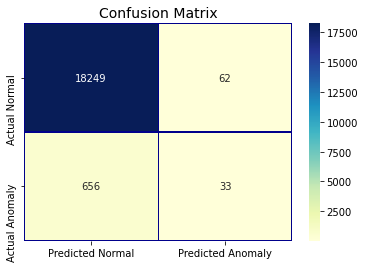

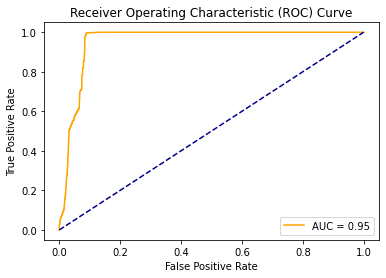

In [ ]:
#Adasyn
get_prediction(IForest(n_estimators = 100, max_samples = 256, contamination = 0.15, random_state= 42), 
                train_X_ada, test_X, train_y_ada, test_y, 'normal', 'IForest', scaler = StandardScaler(), Oversample = True)

On Training Data:
IForest ROC:0.5095, precision @ rank n:0.5365

On Test Data:
IForest ROC:0.5251, precision @ rank n:0.103

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.88      0.92     18311
     Anomaly       0.06      0.19      0.09       689

    accuracy                           0.86     19000
   macro avg       0.51      0.53      0.50     19000
weighted avg       0.93      0.86      0.89     19000


 IForest  Confusion Matrix: 
 [[16121  2190]
 [  560   129]]

 IForest Matthews Correlation Coefficient 0.03862143179530846

 IForest f1-score 0.08577127659574468


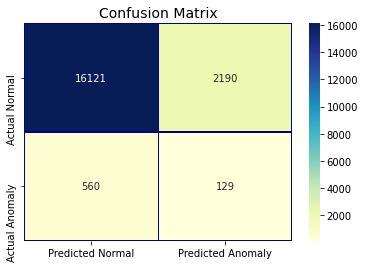

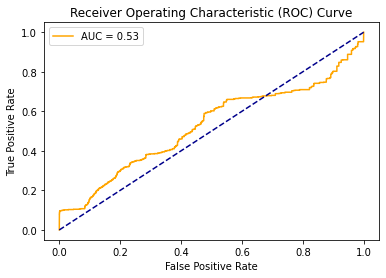

In [ ]:
#Smote
get_prediction(IForest(n_estimators = 100, max_samples = 256, contamination = 0.15, random_state= 42), 
                train_X_smote, test_X, train_y_smote, test_y, 'normal', 'IForest', scaler = StandardScaler(), Oversample = True)

Standardized Not & Oversampled

On Training Data:
IForest ROC:0.941, precision @ rank n:0.2713

On Test Data:
IForest ROC:0.9468, precision @ rank n:0.2859

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.89      0.94     18311
     Anomaly       0.26      1.00      0.41       689

    accuracy                           0.89     19000
   macro avg       0.63      0.94      0.67     19000
weighted avg       0.97      0.89      0.92     19000


 IForest  Confusion Matrix: 
 [[16313  1998]
 [    1   688]]

 IForest Matthews Correlation Coefficient 0.47725015512526636

 IForest f1-score 0.4077037037037037


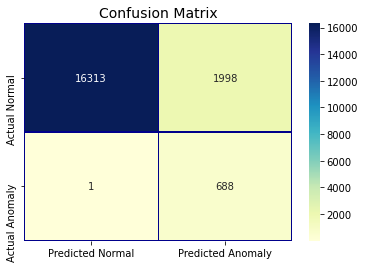

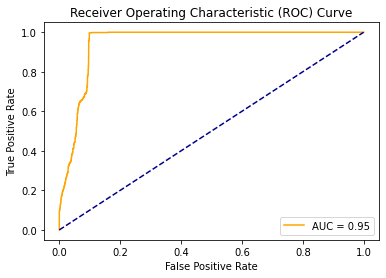

In [ ]:
get_prediction(IForest(n_estimators = 100, max_samples = 256, contamination = 0.15, random_state= 42), 
                train_X, test_X, train_y, test_y, 'normal', 'IForest', scaler = StandardScaler(), Oversample = False)

Not Standardized & Oversampled

On Training Data:
IForest ROC:0.9565, precision @ rank n:0.9046

On Test Data:
IForest ROC:0.9506, precision @ rank n:0.2511

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.99      0.98     18311
     Anomaly       0.24      0.07      0.10       689

    accuracy                           0.96     19000
   macro avg       0.60      0.53      0.54     19000
weighted avg       0.94      0.96      0.95     19000


 IForest  Confusion Matrix: 
 [[18166   145]
 [  644    45]]

 IForest Matthews Correlation Coefficient 0.10783399849863423

 IForest f1-score 0.10238907849829353


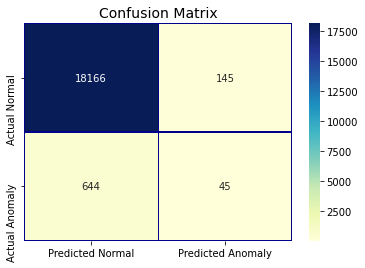

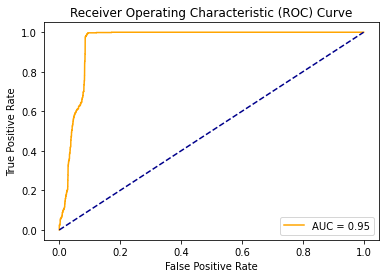

In [ ]:
#Adasyn
get_prediction(IForest(n_estimators = 100, max_samples = 256, contamination = 0.15, random_state= 42), 
                train_X_ada, test_X, train_y_ada, test_y, 'normal', 'IForest', scaler = None, Oversample = True)

On Training Data:
IForest ROC:0.5095, precision @ rank n:0.5365

On Test Data:
IForest ROC:0.5251, precision @ rank n:0.103

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.88      0.92     18311
     Anomaly       0.06      0.19      0.09       689

    accuracy                           0.86     19000
   macro avg       0.51      0.53      0.50     19000
weighted avg       0.93      0.86      0.89     19000


 IForest  Confusion Matrix: 
 [[16121  2190]
 [  560   129]]

 IForest Matthews Correlation Coefficient 0.03862143179530846

 IForest f1-score 0.08577127659574468


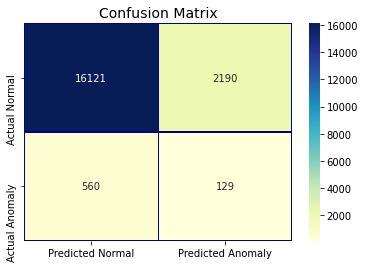

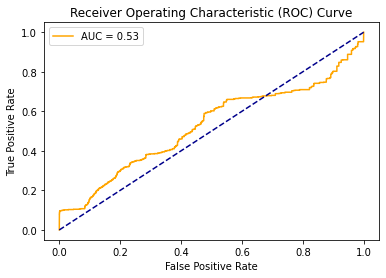

In [ ]:
#Smote
get_prediction(IForest(n_estimators = 100, max_samples = 256, contamination = 0.15, random_state= 42), 
                train_X_smote, test_X, train_y_smote, test_y, 'normal', 'IForest', scaler = None, Oversample = True)

Not Standardized & Not Oversampled

On Training Data:
IForest ROC:0.95, precision @ rank n:0.2561

On Test Data:
IForest ROC:0.9553, precision @ rank n:0.2903

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.89      0.94     18311
     Anomaly       0.26      1.00      0.41       689

    accuracy                           0.90     19000
   macro avg       0.63      0.94      0.68     19000
weighted avg       0.97      0.90      0.92     19000


 IForest  Confusion Matrix: 
 [[16318  1993]
 [    1   688]]

 IForest Matthews Correlation Coefficient 0.477768423286793

 IForest f1-score 0.40830860534124636


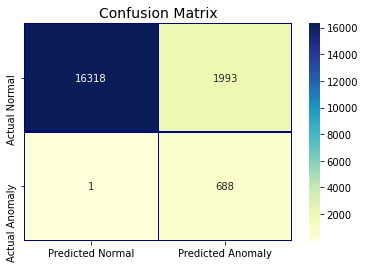

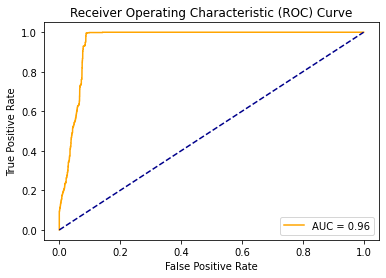

In [ ]:
#Smote
get_prediction(IForest(n_estimators = 100, max_samples = 128, contamination = 0.15, random_state= 42), 
                train_X, test_X, train_y, test_y, 'normal', 'IForest', scaler = None, Oversample = False)

#OCSVM

---



Standardized & Oversampled

On Training Data:
OCSVM ROC:0.7485, precision @ rank n:0.7241

On Test Data:
OCSVM ROC:0.9895, precision @ rank n:0.9361

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.93      0.96     18311
     Anomaly       0.35      0.96      0.51       689

    accuracy                           0.93     19000
   macro avg       0.67      0.95      0.74     19000
weighted avg       0.97      0.93      0.95     19000


 OCSVM  Confusion Matrix: 
 [[17068  1243]
 [   25   664]]

 OCSVM Matthews Correlation Coefficient 0.5573244892211464

 OCSVM f1-score 0.5115562403697997


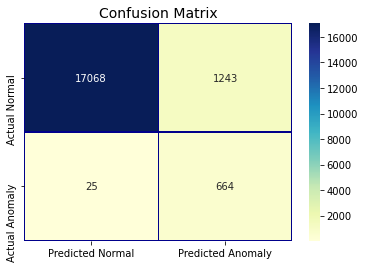

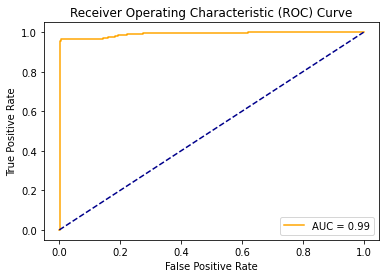

In [ ]:
#Adasyn
get_prediction(OCSVM(gamma = 'scale', contamination= 0.15, kernel = 'rbf'), 
               train_X_ada, test_X, train_y_ada, test_y, 'normal', 'OCSVM', scaler=StandardScaler(), Oversample = True)

On Training Data:
OCSVM ROC:0.562, precision @ rank n:0.4897

On Test Data:
OCSVM ROC:0.5799, precision @ rank n:0.103

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.96      0.85      0.90     18311
     Anomaly       0.04      0.17      0.07       689

    accuracy                           0.83     19000
   macro avg       0.50      0.51      0.48     19000
weighted avg       0.93      0.83      0.87     19000


 OCSVM  Confusion Matrix: 
 [[15593  2718]
 [  574   115]]

 OCSVM Matthews Correlation Coefficient 0.009695488235623244

 OCSVM f1-score 0.06530380465644521


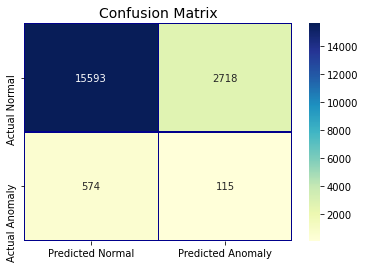

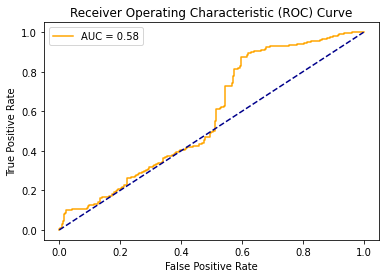

In [ ]:
#Smote
get_prediction(OCSVM(gamma = 'scale', contamination= 0.15, kernel = 'rbf'), 
               train_X_smote, test_X, train_y_smote, test_y, 'normal', 'OCSVM', scaler=StandardScaler(), Oversample = True)

Standardized & Not Oversampled

On Training Data:
OCSVM ROC:0.9725, precision @ rank n:0.3731

On Test Data:
OCSVM ROC:0.9745, precision @ rank n:0.3962

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.89      0.94     18311
     Anomaly       0.25      1.00      0.40       689

    accuracy                           0.89     19000
   macro avg       0.63      0.94      0.67     19000
weighted avg       0.97      0.89      0.92     19000


 OCSVM  Confusion Matrix: 
 [[16277  2034]
 [    0   689]]

 OCSVM Matthews Correlation Coefficient 0.4742604845796781

 OCSVM f1-score 0.40386869871043374


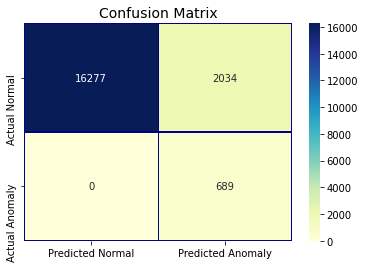

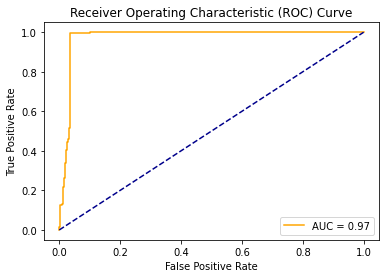

In [ ]:
get_prediction(OCSVM(gamma = 'scale', contamination= 0.15, kernel = 'rbf'), 
               train_X, test_X, train_y, test_y, 'normal', 'OCSVM', scaler=StandardScaler(), Oversample = False)

#LOF

---



Standardized & Oversampled

On Training Data:
LOF ROC:0.408, precision @ rank n:0.4092

On Test Data:
LOF ROC:0.6844, precision @ rank n:0.4688

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.98      0.81      0.89     18311
     Anomaly       0.10      0.58      0.18       689

    accuracy                           0.81     19000
   macro avg       0.54      0.70      0.53     19000
weighted avg       0.95      0.81      0.86     19000


 LOF  Confusion Matrix: 
 [[14914  3397]
 [  292   397]]

 LOF Matthews Correlation Coefficient 0.18269691090468015

 LOF f1-score 0.1771135400401517


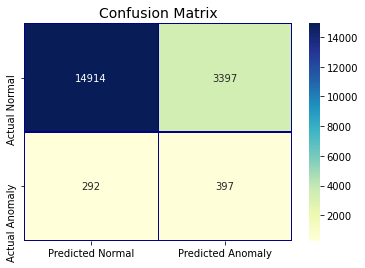

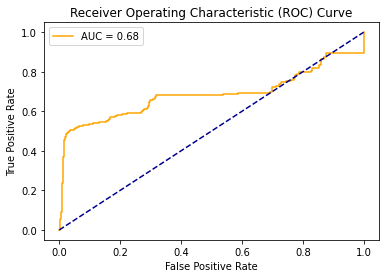

In [ ]:
#Adasyn
get_prediction(LOF(n_neighbors=500, contamination= 0.15, algorithm='auto'), 
               train_X_ada, test_X, train_y_ada, test_y, 'normal', 'LOF', scaler=StandardScaler(), Oversample = True)

On Training Data:
LOF ROC:0.4681, precision @ rank n:0.4324

On Test Data:
LOF ROC:0.4581, precision @ rank n:0.1408

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.89      0.93     18311
     Anomaly       0.06      0.18      0.09       689

    accuracy                           0.87     19000
   macro avg       0.51      0.54      0.51     19000
weighted avg       0.93      0.87      0.90     19000


 LOF  Confusion Matrix: 
 [[16346  1965]
 [  562   127]]

 LOF Matthews Correlation Coefficient 0.04599390332370727

 LOF f1-score 0.09133405249910105


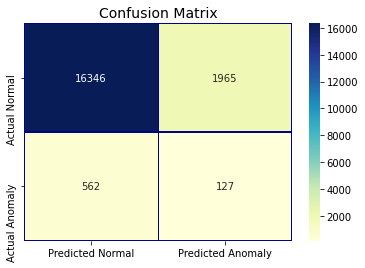

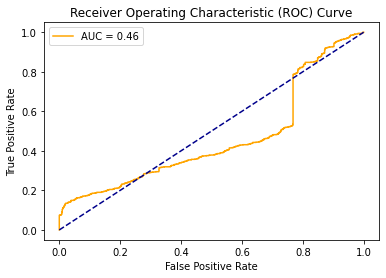

In [ ]:
#Smote
get_prediction(LOF(n_neighbors=500, contamination= 0.15, algorithm='auto'), 
               train_X_smote, test_X, train_y_smote, test_y, 'normal', 'LOF', scaler=StandardScaler(), Oversample = True)

Standardized & Not Oversampled

On Training Data:
LOF ROC:0.6776, precision @ rank n:0.4988

On Test Data:
LOF ROC:0.6844, precision @ rank n:0.4949

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.98      0.87      0.92     18311
     Anomaly       0.14      0.57      0.23       689

    accuracy                           0.86     19000
   macro avg       0.56      0.72      0.57     19000
weighted avg       0.95      0.86      0.90     19000


 LOF  Confusion Matrix: 
 [[15915  2396]
 [  295   394]]

 LOF Matthews Correlation Coefficient 0.23291833260705067

 LOF f1-score 0.226501868352975


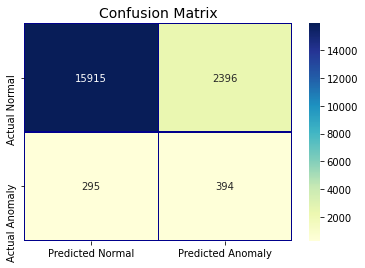

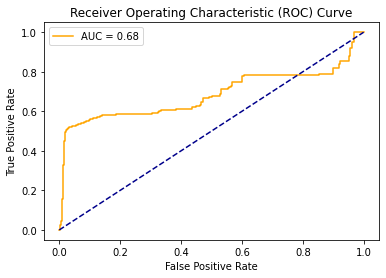

In [ ]:
get_prediction(LOF(n_neighbors=500, contamination= 0.15, algorithm='auto'), 
               train_X, test_X, train_y, test_y, 'normal', 'LOF', scaler=StandardScaler(), Oversample = False)

#CBLOF

---



Standardized & Oversampled

On Training Data:
CBLOF ROC:0.7967, precision @ rank n:0.757

On Test Data:
CBLOF ROC:0.5485, precision @ rank n:0.1205

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.92      0.94     18311
     Anomaly       0.06      0.14      0.09       689

    accuracy                           0.89     19000
   macro avg       0.51      0.53      0.51     19000
weighted avg       0.93      0.89      0.91     19000


 CBLOF  Confusion Matrix: 
 [[16843  1468]
 [  591    98]]

 CBLOF Matthews Correlation Coefficient 0.042190642674538315

 CBLOF f1-score 0.08691796008869178


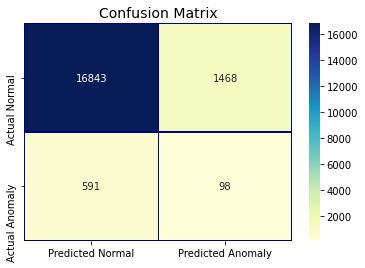

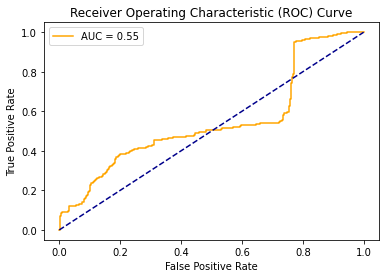

In [ ]:
#Adasyn
get_prediction(CBLOF(contamination= 0.15, n_clusters= 15, alpha= 0.9, beta= 15, random_state=42), 
               train_X_ada, test_X, train_y_ada, test_y, 'normal', 'CBLOF', scaler=StandardScaler(), Oversample = True)

On Training Data:
CBLOF ROC:0.3474, precision @ rank n:0.3644

On Test Data:
CBLOF ROC:0.3713, precision @ rank n:0.1263

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.97      0.86      0.91     18311
     Anomaly       0.05      0.18      0.08       689

    accuracy                           0.84     19000
   macro avg       0.51      0.52      0.49     19000
weighted avg       0.93      0.84      0.88     19000


 CBLOF  Confusion Matrix: 
 [[15770  2541]
 [  562   127]]

 CBLOF Matthews Correlation Coefficient 0.024513155950776383

 CBLOF f1-score 0.07566279416145368


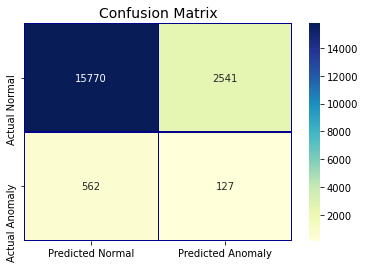

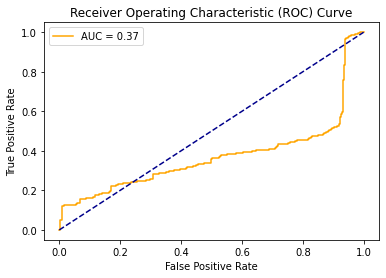

In [ ]:
#Smote
get_prediction(CBLOF(contamination= 0.15, n_clusters= 15, alpha= 0.9, beta= 15, random_state=42), 
               train_X_smote, test_X, train_y_smote, test_y, 'normal', 'CBLOF', scaler=StandardScaler(), Oversample = True)

Standardized & Not Oversampled

On Training Data:
CBLOF ROC:0.9912, precision @ rank n:0.7443

On Test Data:
CBLOF ROC:0.991, precision @ rank n:0.7243

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.89      0.94     18311
     Anomaly       0.25      1.00      0.40       689

    accuracy                           0.89     19000
   macro avg       0.63      0.94      0.67     19000
weighted avg       0.97      0.89      0.92     19000


 CBLOF  Confusion Matrix: 
 [[16263  2048]
 [    0   689]]

 CBLOF Matthews Correlation Coefficient 0.47284250770404673

 CBLOF f1-score 0.4022183304144775


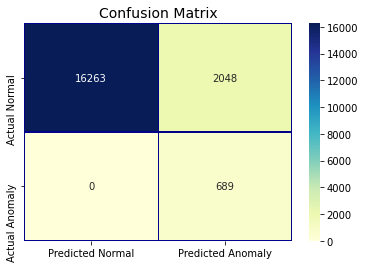

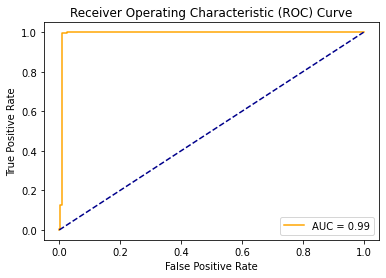

In [ ]:
get_prediction(CBLOF(contamination= 0.15, n_clusters= 15, alpha= 0.9, beta= 15, random_state=42), 
               train_X, test_X, train_y, test_y, 'normal', 'CBLOF', scaler=StandardScaler(), Oversample = False)

#KNN

---



Standardized & Oversampled

On Training Data:
KNN ROC:0.6226, precision @ rank n:0.5931

On Test Data:
KNN ROC:0.5982, precision @ rank n:0.2308

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.98      0.88      0.93     18311
     Anomaly       0.13      0.45      0.20       689

    accuracy                           0.87     19000
   macro avg       0.55      0.67      0.56     19000
weighted avg       0.95      0.87      0.90     19000


 KNN  Confusion Matrix: 
 [[16197  2114]
 [  378   311]]

 KNN Matthews Correlation Coefficient 0.18820475993196548

 KNN f1-score 0.1997430956968529


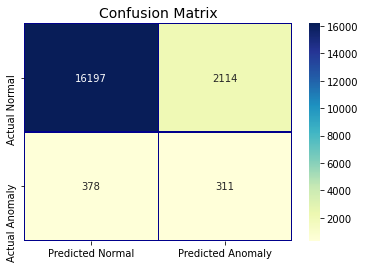

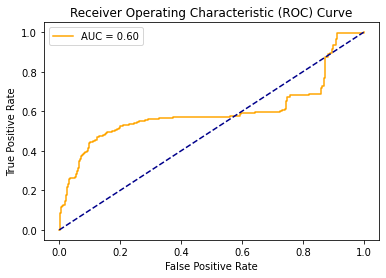

In [ ]:
#Adasyn
get_prediction(KNN(n_neighbors= 500, method= 'largest', algorithm='auto',contamination= 0.15), 
               train_X_ada, test_X, train_y_ada, test_y, 'normal', 'KNN', scaler=StandardScaler(), Oversample = True)

On Training Data:
KNN ROC:0.2523, precision @ rank n:0.2895

On Test Data:
KNN ROC:0.2729, precision @ rank n:0.0464

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.96      0.83      0.89     18311
     Anomaly       0.03      0.15      0.05       689

    accuracy                           0.81     19000
   macro avg       0.50      0.49      0.47     19000
weighted avg       0.93      0.81      0.86     19000


 KNN  Confusion Matrix: 
 [[15221  3090]
 [  584   105]]

 KNN Matthews Correlation Coefficient -0.008175544235661136

 KNN f1-score 0.054067971163748715


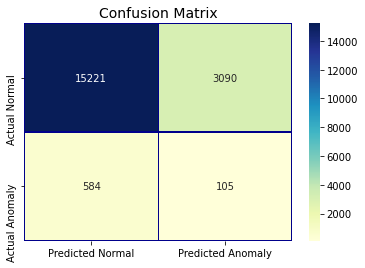

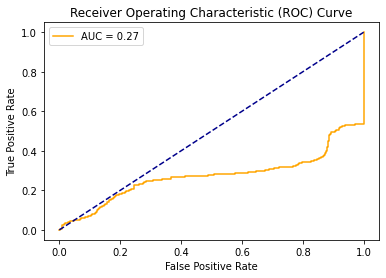

In [ ]:
#Smote
get_prediction(KNN(n_neighbors= 500, method= 'largest', algorithm='auto',contamination= 0.15), 
               train_X_smote, test_X, train_y_smote, test_y, 'normal', 'KNN', scaler=StandardScaler(), Oversample = True)

Standardized & Not Oversampled

On Training Data:
KNN ROC:0.5957, precision @ rank n:0.2526

On Test Data:
KNN ROC:0.6054, precision @ rank n:0.2612

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.98      0.87      0.92     18311
     Anomaly       0.12      0.47      0.19       689

    accuracy                           0.85     19000
   macro avg       0.55      0.67      0.55     19000
weighted avg       0.95      0.85      0.89     19000


 KNN  Confusion Matrix: 
 [[15868  2443]
 [  362   327]]

 KNN Matthews Correlation Coefficient 0.1807402583121506

 KNN f1-score 0.189071986123157


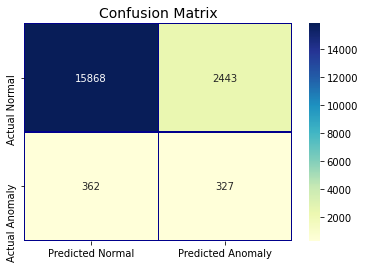

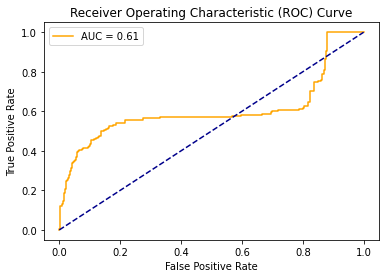

In [ ]:
get_prediction(KNN(n_neighbors= 500, method= 'largest', algorithm='auto',contamination= 0.15), 
               train_X, test_X, train_y, test_y, 'normal', 'KNN', scaler=StandardScaler(), Oversample = False)

#Isotree-IsolationForest


---





Standardized & Oversampled


 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     18311
           1       0.04      1.00      0.07       689

    accuracy                           0.04     19000
   macro avg       0.02      0.50      0.03     19000
weighted avg       0.00      0.04      0.00     19000


 IForest  Confusion Matrix: 
 [[    0 18311]
 [    0   689]]

 IForest Matthews Correlation Coefficient 0.0

 IForest f1-score 0.06998831835034793


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


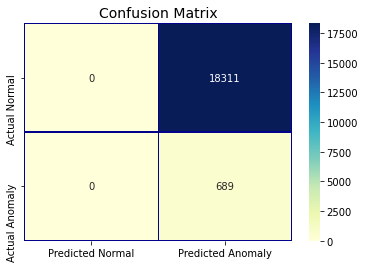

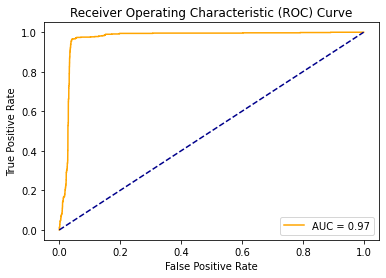

In [ ]:
#Adasyn
get_prediction_iso(IsolationForest(sample_size = 256, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X_ada, test_X, train_y_ada, test_y, 'normal', 'IForest', scaler=StandardScaler(), Oversample = True)


 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.69      0.81     18311
           1       0.04      0.38      0.08       689

    accuracy                           0.68     19000
   macro avg       0.51      0.54      0.44     19000
weighted avg       0.93      0.68      0.78     19000


 IForest  Confusion Matrix: 
 [[12635  5676]
 [  424   265]]

 IForest Matthews Correlation Coefficient 0.030098135466583492

 IForest f1-score 0.07993966817496229


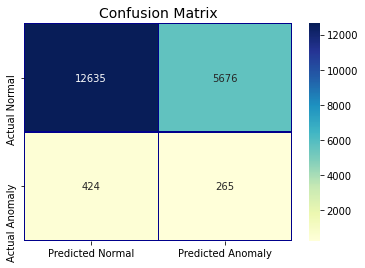

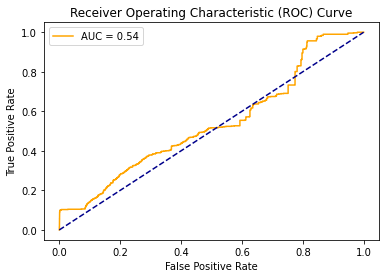

In [ ]:
#Smote
get_prediction_iso(IsolationForest(sample_size = 256, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X_smote, test_X, train_y_smote, test_y, 'normal', 'IForest', scaler=StandardScaler(), Oversample = True)

Standardized & Not Oversampled


 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     18311
           1       0.28      1.00      0.44       689

    accuracy                           0.91     19000
   macro avg       0.64      0.95      0.69     19000
weighted avg       0.97      0.91      0.93     19000


 IForest  Confusion Matrix: 
 [[16543  1768]
 [    1   688]]

 IForest Matthews Correlation Coefficient 0.5026146647360058

 IForest f1-score 0.4375198728139905


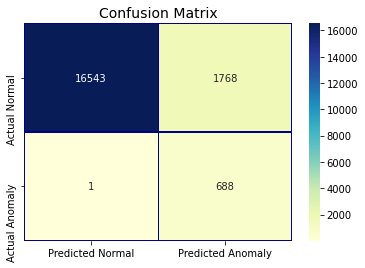

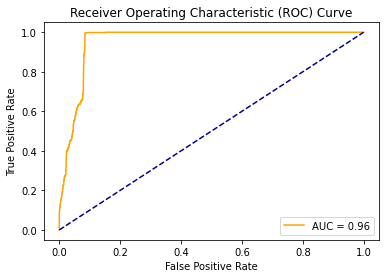

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 128, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'normal', 'IForest', scaler=StandardScaler(), Oversample = False)

Not Standardized & Oversampled


 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     18311
           1       0.18      0.47      0.26       689

    accuracy                           0.90     19000
   macro avg       0.58      0.69      0.60     19000
weighted avg       0.95      0.90      0.92     19000


 IForest  Confusion Matrix: 
 [[16812  1499]
 [  365   324]]

 IForest Matthews Correlation Coefficient 0.24652404206150771

 IForest f1-score 0.25796178343949044


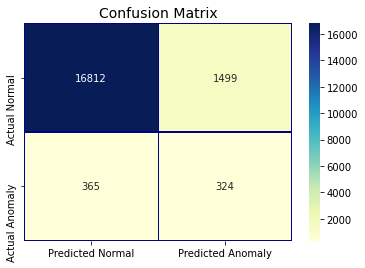

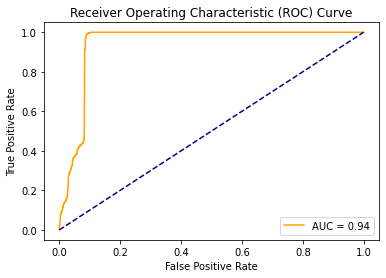

In [ ]:
#Adasyn
get_prediction_iso(IsolationForest(sample_size = 128, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X_ada, test_X, train_y_ada, test_y, 'normal', 'IForest', scaler=None, Oversample = True)


 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     18311
           1       0.05      0.13      0.08       689

    accuracy                           0.88     19000
   macro avg       0.51      0.52      0.51     19000
weighted avg       0.93      0.88      0.91     19000


 IForest  Confusion Matrix: 
 [[16712  1599]
 [  599    90]]

 IForest Matthews Correlation Coefficient 0.028442840146120526

 IForest f1-score 0.07569386038687974


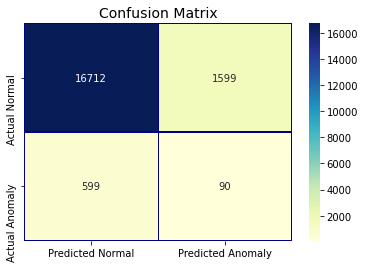

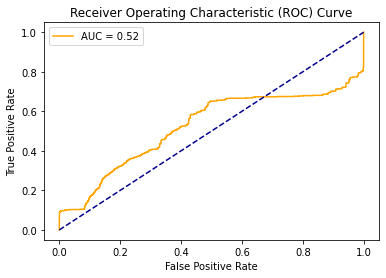

In [ ]:
#Smote
get_prediction_iso(IsolationForest(sample_size = 128, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X_smote, test_X, train_y_smote, test_y, 'normal', 'IForest', scaler=None, Oversample = True)

Not Standardized & Not Oversampled


 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     18311
           1       0.28      1.00      0.44       689

    accuracy                           0.91     19000
   macro avg       0.64      0.95      0.69     19000
weighted avg       0.97      0.91      0.93     19000


 IForest  Confusion Matrix: 
 [[16561  1750]
 [    1   688]]

 IForest Matthews Correlation Coefficient 0.5047419531280657

 IForest f1-score 0.44003837543971863


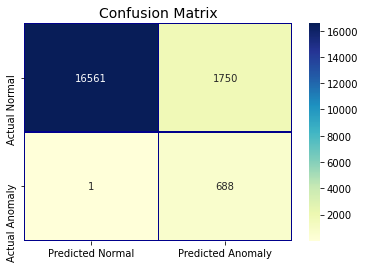

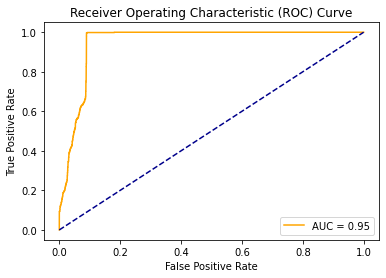

In [ ]:
#Does not work well on oversampled data
get_prediction_iso(IsolationForest(sample_size = 128, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'normal', 'IForest', scaler=None, Oversample = False)

#Isotree-SciForest

---



Standardized & Oversampled


 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     18311
           1       0.04      1.00      0.07       689

    accuracy                           0.04     19000
   macro avg       0.02      0.50      0.03     19000
weighted avg       0.00      0.04      0.00     19000


 SciForest  Confusion Matrix: 
 [[    0 18311]
 [    0   689]]

 SciForest Matthews Correlation Coefficient 0.0

 SciForest f1-score 0.06998831835034793


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


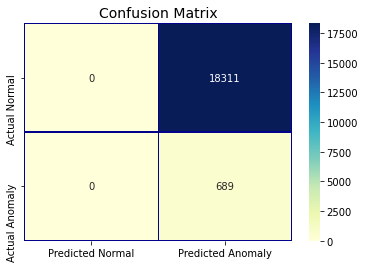

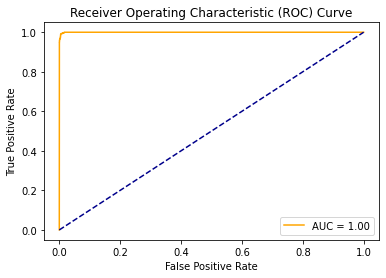

In [ ]:
#Adasyn
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_ada, test_X, train_y_ada, test_y, 'normal', 'SciForest', scaler=StandardScaler(), Oversample = True)


 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     18311
           1       0.04      1.00      0.07       689

    accuracy                           0.04     19000
   macro avg       0.02      0.50      0.03     19000
weighted avg       0.00      0.04      0.00     19000


 SciForest  Confusion Matrix: 
 [[    0 18311]
 [    0   689]]

 SciForest Matthews Correlation Coefficient 0.0

 SciForest f1-score 0.06998831835034793


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


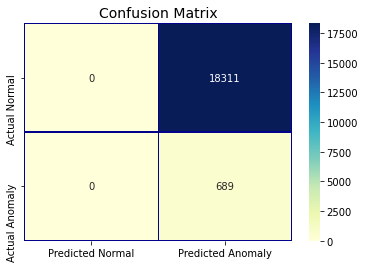

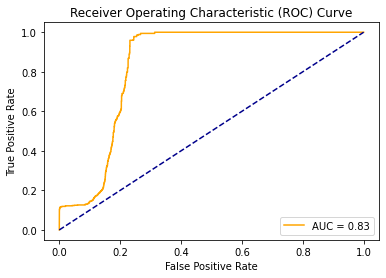

In [ ]:
#Smote
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_smote, test_X, train_y_smote, test_y, 'normal', 'SciForest', scaler=StandardScaler(), Oversample = True)

Standardized & Not Oversampled


 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     18311
           1       0.35      1.00      0.52       689

    accuracy                           0.93     19000
   macro avg       0.67      0.96      0.74     19000
weighted avg       0.98      0.93      0.95     19000


 SciForest  Confusion Matrix: 
 [[17029  1282]
 [    1   688]]

 SciForest Matthews Correlation Coefficient 0.5694085444117952

 SciForest f1-score 0.5174877773599097


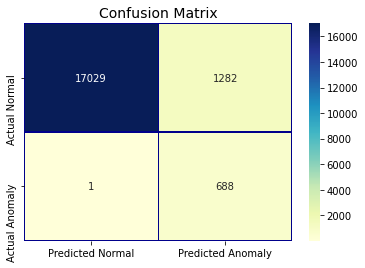

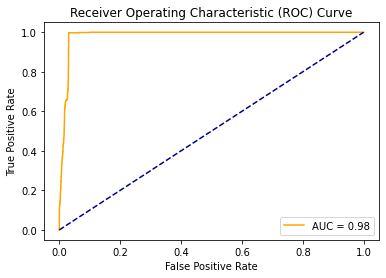

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'normal', 'SciForest', scaler=StandardScaler(), Oversample = False)

Not Standardized & Oversampled


 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96     18311
           1       0.31      0.91      0.46       689

    accuracy                           0.92     19000
   macro avg       0.65      0.92      0.71     19000
weighted avg       0.97      0.92      0.94     19000


 SciForest  Confusion Matrix: 
 [[16887  1424]
 [   62   627]]

 SciForest Matthews Correlation Coefficient 0.5013754185048591

 SciForest f1-score 0.45766423357664227


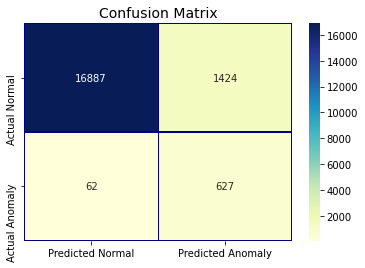

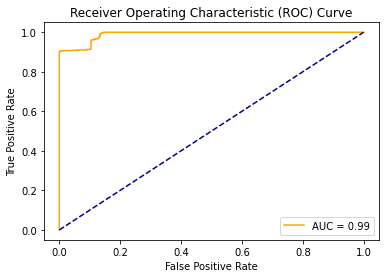

In [ ]:
#Adasyn
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_ada, test_X, train_y_ada, test_y, 'normal', 'SciForest', scaler=None, Oversample = True)


 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     18311
           1       0.05      0.13      0.07       689

    accuracy                           0.88     19000
   macro avg       0.51      0.52      0.51     19000
weighted avg       0.93      0.88      0.91     19000


 SciForest  Confusion Matrix: 
 [[16663  1648]
 [  599    90]]

 SciForest Matthews Correlation Coefficient 0.026343473516655752

 SciForest f1-score 0.07416563658838073


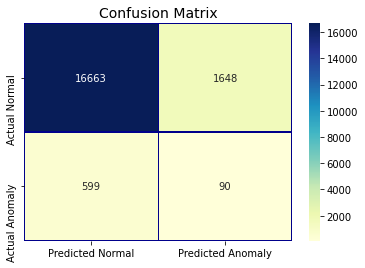

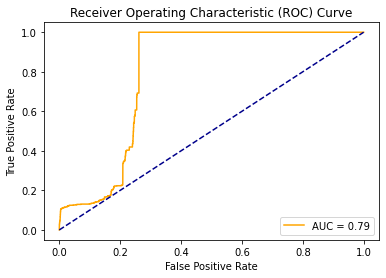

In [ ]:
##Smote
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_smote, test_X, train_y_smote, test_y, 'normal', 'SciForest', scaler=None, Oversample = True)

Not Standardized & Not Oversampled


 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     18311
           1       0.38      1.00      0.55       689

    accuracy                           0.94     19000
   macro avg       0.69      0.97      0.76     19000
weighted avg       0.98      0.94      0.95     19000


 SciForest  Confusion Matrix: 
 [[17198  1113]
 [    1   688]]

 SciForest Matthews Correlation Coefficient 0.5984824671117398

 SciForest f1-score 0.5526104417670683


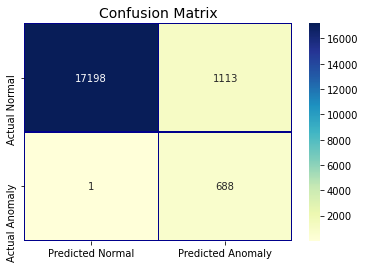

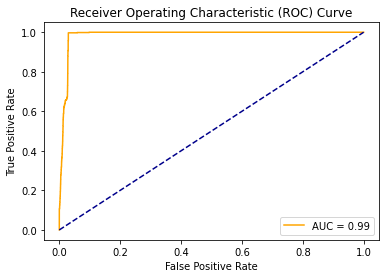

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'normal', 'SciForest', scaler=None, Oversample = False)